<a href="https://colab.research.google.com/github/mkatogui/FAO_Area_Harvested/blob/main/Predicci%C3%B3n_de_Overbooking.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import random
from datetime import datetime, timedelta

# Semilla para reproducibilidad
np.random.seed(123)

# Variables base
aeropuertos = ["MAD", "BCN", "AGP", "SVQ", "VLC"]
destinos = ["LHR", "CDG", "FRA", "AMS", "FCO"]
tarifas = ["reembolsable", "no_reembolsable"]

# Fechas y festivos
fechas = pd.date_range(start="2024-01-01", end="2024-12-31")
festivos = pd.to_datetime([
    "2024-01-06", "2024-04-01", "2024-05-01",
    "2024-08-15", "2024-10-12", "2024-12-25"
])

# Simulación de datos
n = 5000
df = pd.DataFrame({
    "precio": np.round(np.random.uniform(50, 500, n), 2),
    "tarifa": np.random.choice(tarifas, n, p=[0.3, 0.7]),
    "destino": np.random.choice(destinos, n),
    "aeropuerto": np.random.choice(aeropuertos, n),
    "fecha_vuelo": np.random.choice(fechas, n)
})

# Marcar si el vuelo es en festivo
df["es_festivo"] = df["fecha_vuelo"].isin(festivos).astype(int)

# Simular overbooking con una regla básica
df["overbooked"] = np.where(
    (df["tarifa"] == "no_reembolsable") & (df["precio"] < 150) & (df["es_festivo"] == 1) |
    ((df["aeropuerto"] == "MAD") & (df["destino"] == "LHR") & (df["precio"] < 200)),
    1, 0
)

df.head()


,precio,tarifa,destino,aeropuerto,fecha_vuelo,es_festivo,overbooked
0,363.41,no_reembolsable,FRA,AGP,2024-03-31,0,0
1,178.76,reembolsable,FCO,BCN,2024-08-10,0,0
2,152.08,no_reembolsable,FCO,MAD,2024-01-07,0,0
3,298.09,no_reembolsable,FCO,SVQ,2024-11-04,0,0
4,373.76,no_reembolsable,LHR,AGP,2024-10-02,0,0


In [2]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder

# Codificar variables categóricas
df_encoded = df.copy()
label_cols = ["tarifa", "destino", "aeropuerto"]
label_encoders = {}

for col in label_cols:
    le = LabelEncoder()
    df_encoded[col] = le.fit_transform(df[col])
    label_encoders[col] = le

# División train/test
X = df_encoded[["precio", "tarifa", "destino", "aeropuerto", "es_festivo"]]
y = df_encoded["overbooked"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Entrenar modelo
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Predicción
y_pred = rf.predict(X_test)

# Evaluación
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


[[1482    0]
 [   1   17]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1482
           1       1.00      0.94      0.97        18

    accuracy                           1.00      1500
   macro avg       1.00      0.97      0.99      1500
weighted avg       1.00      1.00      1.00      1500



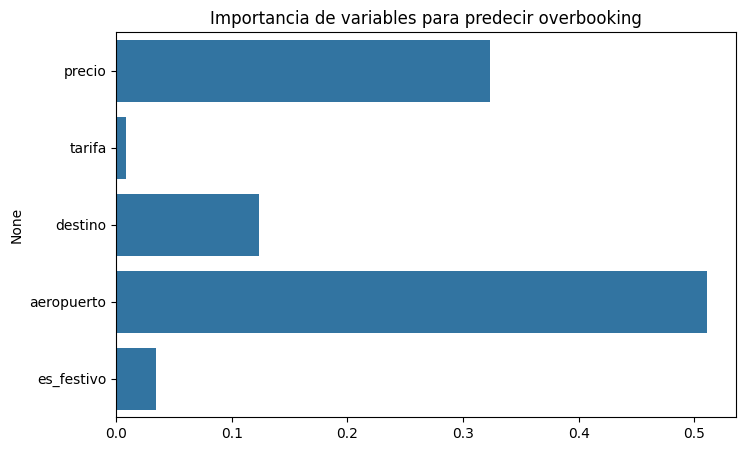

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

importancia = rf.feature_importances_
features = X.columns

plt.figure(figsize=(8, 5))
sns.barplot(x=importancia, y=features)
plt.title("Importancia de variables para predecir overbooking")
plt.show()
